In [42]:
from elasticsearch import Elasticsearch, exceptions as es_exceptions
from elasticsearch.helpers import scan
es = Elasticsearch([{'host':'uct2-es-door.mwt2.org', 'port':9200}])

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
%matplotlib inline
plt.style.use('ggplot')

In [43]:
ind="stashcp-2016.7"

myquery1={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1467433769609,
                  "lte": 1467437864765,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

#2 submits
myquery2={
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "*",
          "analyze_wildcard": True
        }
      },
      "filter": {
        "bool": {
          "must": [
            {
              "query": {
                "query_string": {
                  "analyze_wildcard": True,
                  "query": "*"
                }
              }
            },
            {
              "range": {
                "timestamp": {
                  "gte": 1467748838181,
                  "lte": 1467751501650,
                  "format": "epoch_millis"
                }
              }
            }
          ],
        }
      }
    }
  },
}

In [44]:
page= es.search(index=ind, body=myquery2, scroll='2m', search_type='scan', size=1)

sid = page['_scroll_id']

scroll_size = page['hits']['total']
results=[]

while (scroll_size > 0):
    page = es.scroll(scroll_id = sid, scroll = '2m')
    results.append(page['hits']['hits'])
    sid = page['_scroll_id']
    scroll_size = len(page['hits']['hits'])

scroll_size = page['hits']['total']
Res=[]
for i in range(0,scroll_size):
    Res.append(results[i][0]['_source'])
    
print(scroll_size)

df = pd.DataFrame(Res)
#print(df.head(2))

del df['destination_space']
del df['xrdcp_version']
#del df['tries']
del df['download_size']
del df['filesize']
del df['IP']
del df['xrdcp_exit']

begin=[]
for i in range(scroll_size):
    begin.append((int(df['timestamp'][i])-int(df['download_time'][i]))) #convert to minutes
    
df['begin']=begin
print(list(df.columns.values))
print(df.head(1))

957
['cache', 'download_time', 'end1', 'end2', 'filename', 'host', 'sitename', 'start1', 'start2', 'start3', 'status', 'timestamp', 'tries', 'begin']
                                               cache download_time  \
0  root://mwt2-stashcache.campuscluster.illinois.edu         63874   

            end1 end2                           filename  \
0  1467748955403    0  user/taburaad/public/2gb_file.tar   

                                                host sitename         start1  \
0  root://mwt2-stashcache.campuscluster.illinois.edu   osg-ce  1467748891529   

  start2 start3   status      timestamp tries          begin  
0      0      0  Success  1467748955000     1  1467748891126  


In [45]:
length=df.shape[0]

for i in range(length):
    begin=int(df['begin'].iloc[i])//1000
    end=int(df['timestamp'].iloc[i])//1000
    start1=int(df['start1'].iloc[i])//1000
    end1=int(df['end1'].iloc[i])//1000
    start2=int(df['start2'].iloc[i])//1000
    end2=int(df['end2'].iloc[i])//1000
    start3=int(df['start3'].iloc[i])//1000
    df['begin'].iloc[i]=datetime.datetime.fromtimestamp(begin).strftime('%Y-%m-%d %H:%M:%S')
    df['timestamp'].iloc[i]=datetime.datetime.fromtimestamp(end).strftime('%Y-%m-%d %H:%M:%S')  
    df['start1'].iloc[i]=datetime.datetime.fromtimestamp(start1).strftime('%Y-%m-%d %H:%M:%S')
    df['start2'].iloc[i]=datetime.datetime.fromtimestamp(start2).strftime('%Y-%m-%d %H:%M:%S')
    df['start3'].iloc[i]=datetime.datetime.fromtimestamp(start3).strftime('%Y-%m-%d %H:%M:%S')
    df['end1'].iloc[i]=datetime.datetime.fromtimestamp(end1).strftime('%Y-%m-%d %H:%M:%S')
    df['end2'].iloc[i]=datetime.datetime.fromtimestamp(end2).strftime('%Y-%m-%d %H:%M:%S')


    
df=df.set_index(['timestamp'])    
df.index = pd.to_datetime(df.index, unit='s')
df['begin']=pd.to_datetime(df.begin, unit='s')
df['start1']=pd.to_datetime(df.begin, unit='s')
df['start2']=pd.to_datetime(df.begin, unit='s')
df['start3']=pd.to_datetime(df.begin, unit='s')
df['end1']=pd.to_datetime(df.begin, unit='s')
df['end2']=pd.to_datetime(df.begin, unit='s')
df

/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,cache,download_time,end1,end2,filename,host,sitename,start1,start2,start3,status,tries,begin
timestamp,,,,,,,,,,,,,
2016-07-05 15:02:35,root://mwt2-stashcache.campuscluster.illinois.edu,63874,2016-07-05 15:01:31,2016-07-05 15:01:31,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,2016-07-05 15:01:31,2016-07-05 15:01:31,2016-07-05 15:01:31,Success,1,2016-07-05 15:01:31
2016-07-05 15:02:38,root://mwt2-stashcache.campuscluster.illinois.edu,67510,2016-07-05 15:01:30,2016-07-05 15:01:30,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,2016-07-05 15:01:30,2016-07-05 15:01:30,2016-07-05 15:01:30,Success,1,2016-07-05 15:01:30
2016-07-05 15:02:45,root://mwt2-stashcache.campuscluster.illinois.edu,68457,2016-07-05 15:01:36,2016-07-05 15:01:36,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,2016-07-05 15:01:36,2016-07-05 15:01:36,2016-07-05 15:01:36,Success,1,2016-07-05 15:01:36
2016-07-05 15:03:02,root://mwt2-stashcache.campuscluster.illinois.edu,85268,2016-07-05 15:01:36,2016-07-05 15:01:36,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,2016-07-05 15:01:36,2016-07-05 15:01:36,2016-07-05 15:01:36,Success,1,2016-07-05 15:01:36
2016-07-05 15:03:11,root://data.ci-connect.net,8991,2016-07-05 15:03:02,2016-07-05 15:03:02,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-05 15:03:02,2016-07-05 15:03:02,2016-07-05 15:03:02,Success,1,2016-07-05 15:03:02
2016-07-05 15:03:17,root://data.ci-connect.net,16130,2016-07-05 15:03:00,2016-07-05 15:03:00,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-05 15:03:00,2016-07-05 15:03:00,2016-07-05 15:03:00,Success,1,2016-07-05 15:03:00
2016-07-05 15:03:22,root://mwt2-stashcache.campuscluster.illinois.edu,97780,2016-07-05 15:01:44,2016-07-05 15:01:44,user/taburaad/public/2gb_file.tar,root://mwt2-stashcache.campuscluster.illinois.edu,osg-ce,2016-07-05 15:01:44,2016-07-05 15:01:44,2016-07-05 15:01:44,Success,1,2016-07-05 15:01:44
2016-07-05 15:04:21,root://data.ci-connect.net,35057,2016-07-05 15:03:45,2016-07-05 15:03:45,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-05 15:03:45,2016-07-05 15:03:45,2016-07-05 15:03:45,Success,1,2016-07-05 15:03:45
2016-07-05 15:04:22,root://data.ci-connect.net,26178,2016-07-05 15:03:55,2016-07-05 15:03:55,user/taburaad/public/2gb_file.tar,root://data.ci-connect.net,MWT2_CE_UIUC,2016-07-05 15:03:55,2016-07-05 15:03:55,2016-07-05 15:03:55,Success,1,2016-07-05 15:03:55


In [46]:
df.to_pickle('jobtest.pkl') 

type(df['start1'].iloc[1])

pandas.tslib.Timestamp

In [47]:
jobs = pd.concat([pd.Series(1, df.begin), pd.Series(-1, df.index)]).resample('1Min', how='sum').cumsum()
index=jobs.index

df2=pd.DataFrame(columns=['index', 'Origin', 'Nebraska', 'UCSD', 'US-MWT2_UIUC', 'BNL ATLAS', 'FZU', 'Trunk'])
df2['index']=index

length2=df2.shape[0]
df2['Origin']=0
df2['Nebraska']=0
df2['UCSD']=0
df2['US-MWT2_UIUC']=0
df2['BNL ATLAS']=0
df2['FZU']=0
df2['Trunk']=0


for i in range(length2):
    for j in range(length):
        if df['tries'].iloc[j]==1:
            if df['begin'].iloc[j]<=df2['index'].iloc[i] and df.index[j]>=df2['index'].iloc[i]:
                if df['host'].iloc[j]=='root://data.ci-connect.net':
                    df2['Origin'].iloc[i]+=1
                if df['host'].iloc[j]=='root://hcc-stash.unl.edu':
                    df2['Nebraska'].iloc[i]+=1
                if df['host'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                    df2['US-MWT2_UIUC'].iloc[i]+=1
                if df['host'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                    df2['UCSD'].iloc[i]+=1
                if df['host'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                    df2['BNL ATLAS'].iloc[i]+=1
                if df['host'].iloc[j]=='novastore.farm.particle.cz':
                    df2['FZU'].iloc[i]+=1
        elif df['tries'].iloc[j]!=1:
            if df['start2'].iloc[j]<=df2['index'].iloc[i] and df.index[j]>=df2['index'].iloc[i]:
                if df['cache'].iloc[j]=='root://hcc-stash.unl.edu':
                    df2['Nebraska'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://mwt2-stashcache.campuscluster.illinois.edu':
                    df2['US-MWT2_UIUC'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://xrd-cache-1.t2.ucsd.edu':
                    df2['UCSD'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://osgxroot.usatlas.bnl.gov':
                    df2['BNL ATLAS'].iloc[i]+=1
                if df['cache'].iloc[j]=='novastore.farm.particle.cz':
                    df2['FZU'].iloc[i]+=1
                if df['cache'].iloc[j]=='root://data.ci-connect.net':
                    if df['tries'].iloc[j]==2:
                        df2['Origin'].iloc[i]+=1
                    else:
                        df2['Trunk'].iloc[i]+=1




df2



/home/ivukotic/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  if __name__ == '__main__':
/home/ivukotic/anaconda3/lib/python3.5/site-packages/pandas/core/indexing.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,index,Origin,Nebraska,UCSD,US-MWT2_UIUC,BNL ATLAS,FZU,Trunk
0,2016-07-05 15:01:00,0,0,0,0,0,0,0
1,2016-07-05 15:02:00,0,0,0,12,1,0,0
2,2016-07-05 15:03:00,0,0,2,12,1,0,1
3,2016-07-05 15:04:00,0,67,31,34,2,0,64
4,2016-07-05 15:05:00,0,59,32,31,8,0,67
5,2016-07-05 15:06:00,0,71,34,31,33,0,72
6,2016-07-05 15:07:00,0,64,38,70,161,0,73
7,2016-07-05 15:08:00,0,68,37,76,163,0,73
8,2016-07-05 15:09:00,0,68,45,75,167,0,73
9,2016-07-05 15:10:00,0,45,43,38,168,0,53


In [48]:
#df2

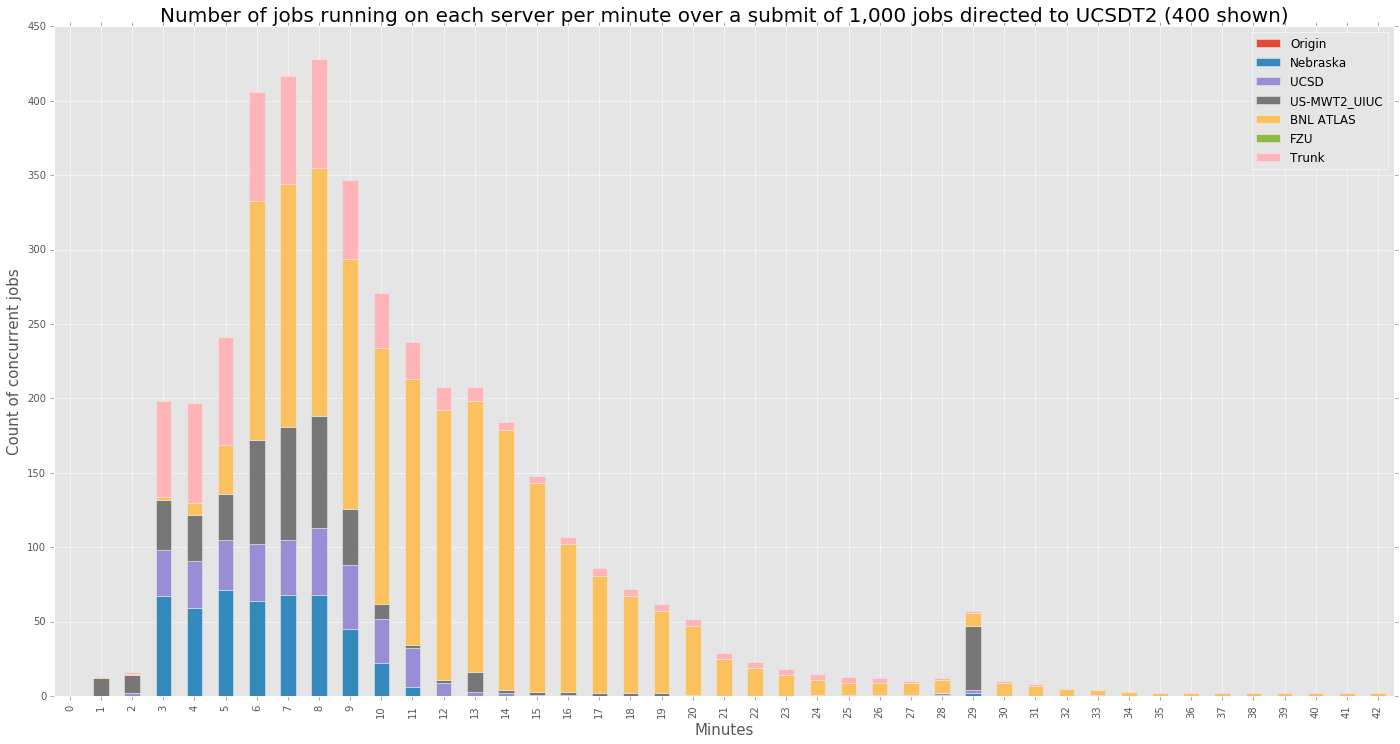

In [50]:
df2.plot.bar(stacked=True,figsize=[24, 12])
plt.title('Number of jobs running on each server per minute over a submit of 1,000 jobs directed to UCSDT2 (400 shown)', fontsize=20) 
plt.xlabel('Minutes', fontsize=15)
plt.ylabel('Count of concurrent jobs',fontsize=15)
#plt.text(60,55,'*No GLIDEIN_ResourceName specified in condor.submit')
#plt.savefig('Ilija_plot1_2.png')
